In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import quantile_transform, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE

import xgboost as xgb

%config InlineBackend.figure_format = 'png'
%matplotlib inline

In [3]:
train_data = pd.read_csv('/content/gdrive/MyDrive/MercedezData/train.csv')
train_data

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [4]:
test_data = pd.read_csv('/content/gdrive/MyDrive/MercedezData/test.csv')

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


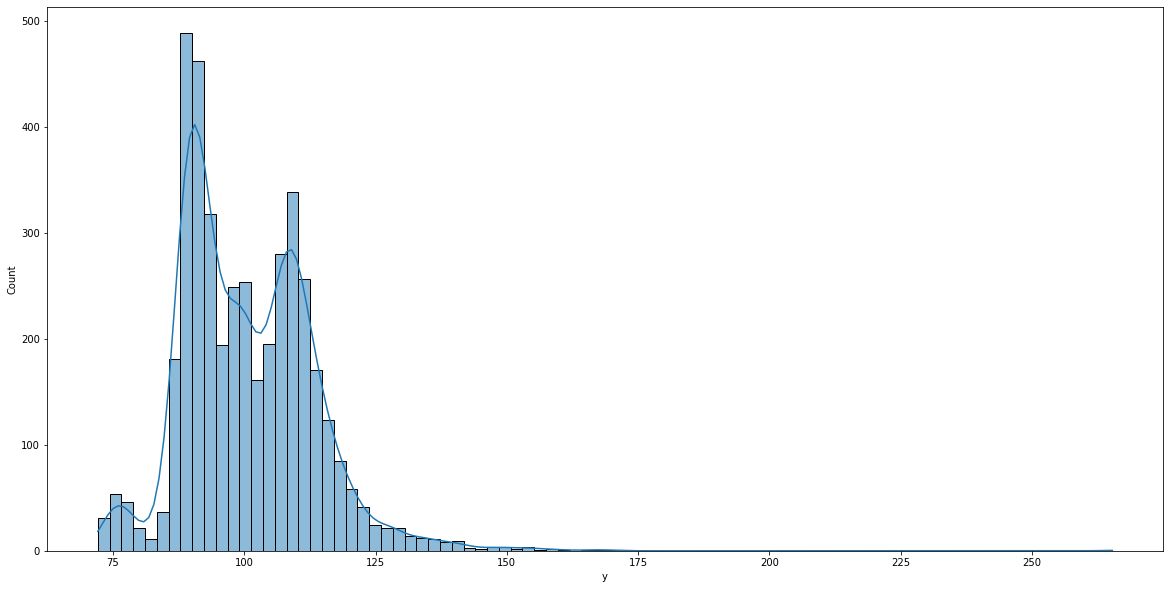

In [6]:
target = train_data['y'].copy()
plt.figure(figsize=(20,10))
sns.histplot(target, kde=True)

In [7]:
np.where(train_data.dtypes=='object') # категориальные признаки

(array([2, 3, 4, 5, 6, 7, 8, 9]),)

In [8]:
len(np.where(train_data.dtypes=='int64')[0]) # число бинарных признаков

369

In [9]:
np.where(train_data.isnull()) # пропущенных значений нет

(array([], dtype=int64), array([], dtype=int64))

### Categorical features

In [10]:
cat_indexes = np.where(train_data.dtypes=='object')
cat_columns = train_data.columns[cat_indexes]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

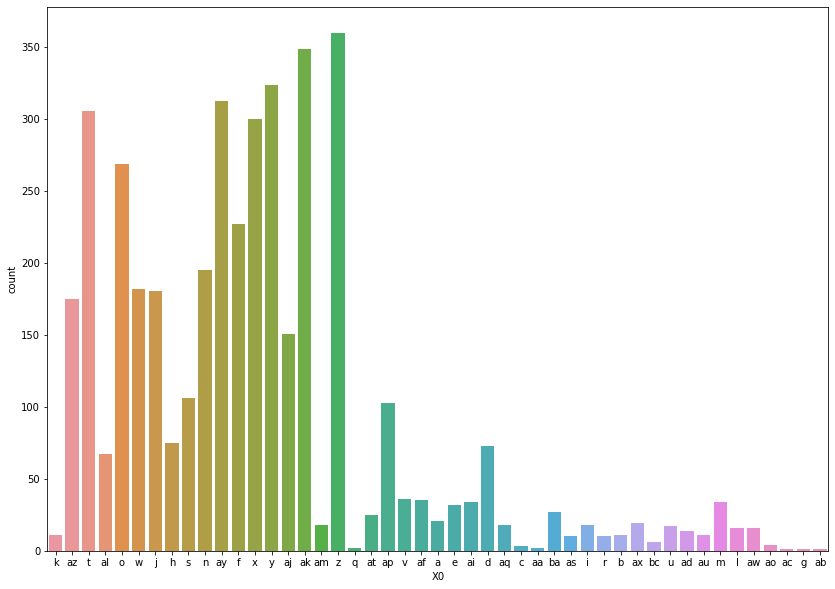

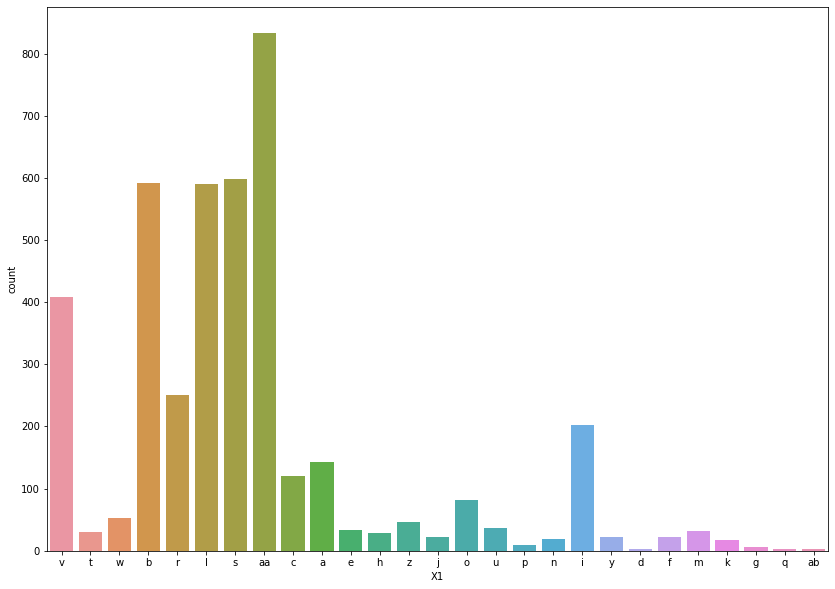

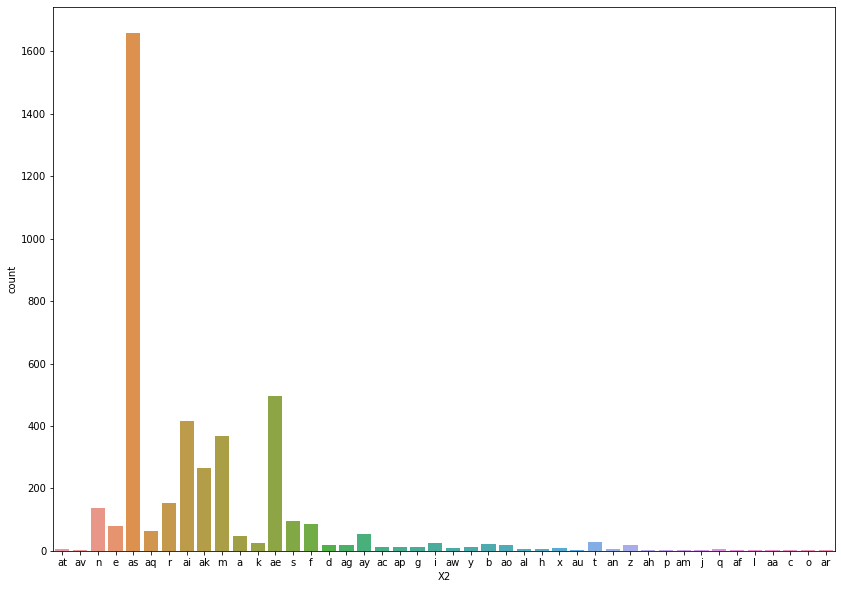

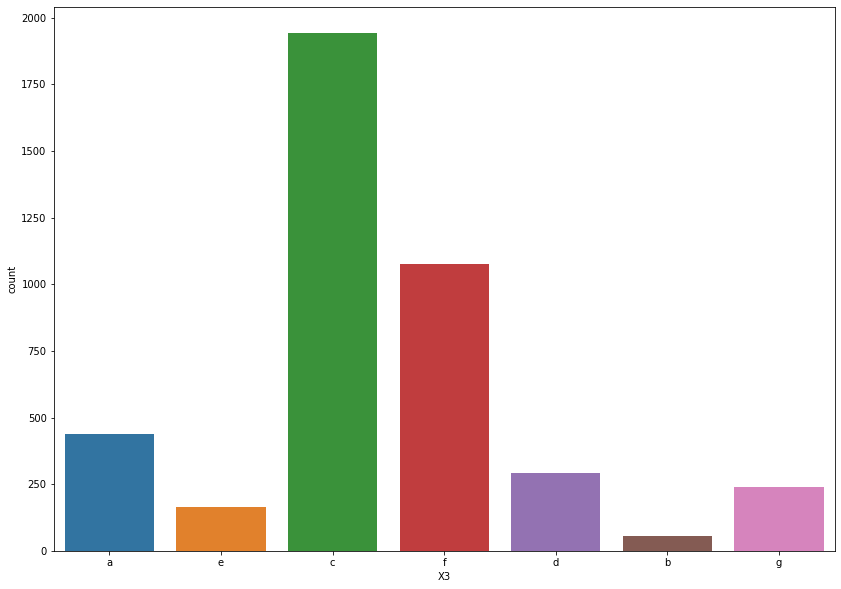

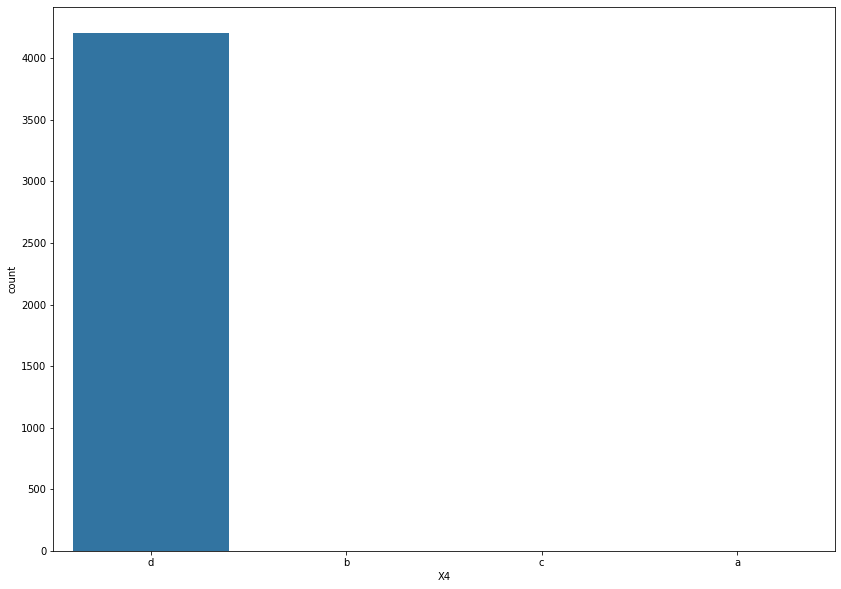

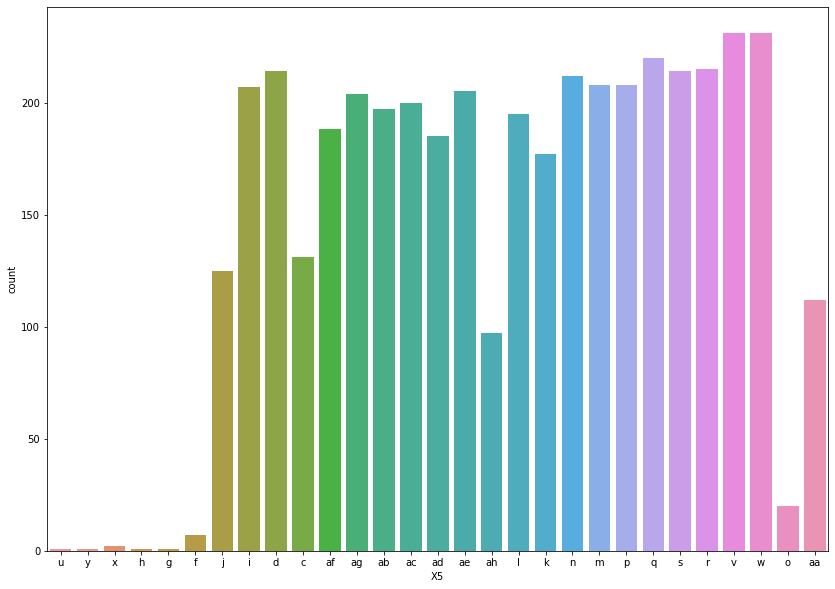

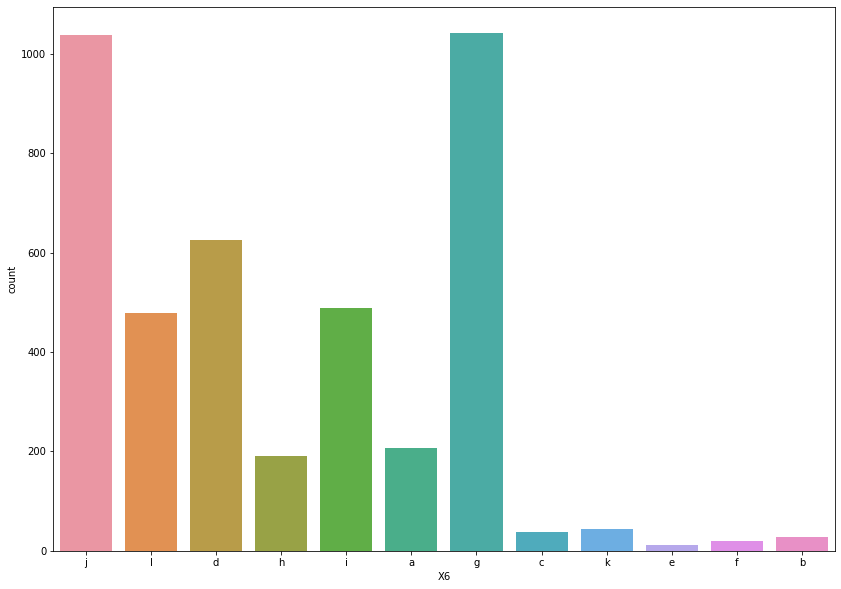

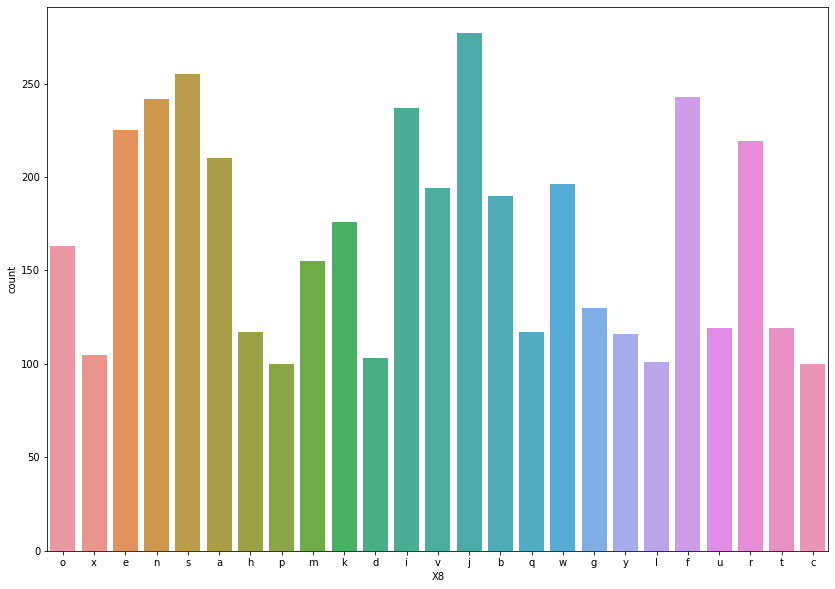

In [ ]:
for c in cat_columns:
  plt.figure(figsize=(14,10))
  sns.countplot(train_data[c])

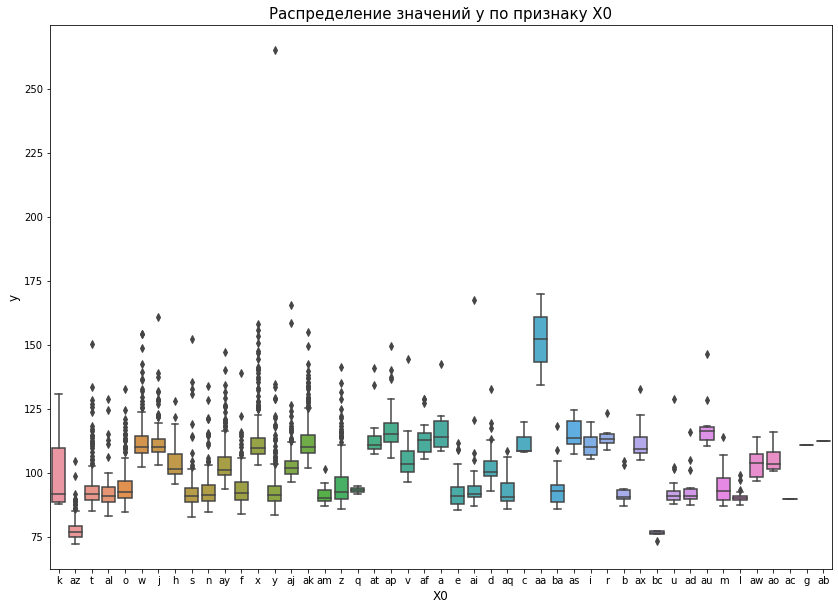

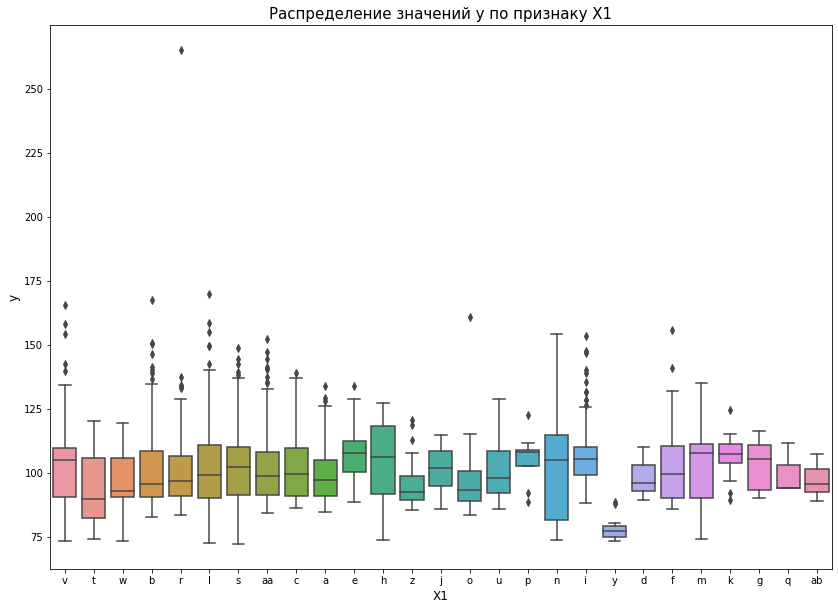

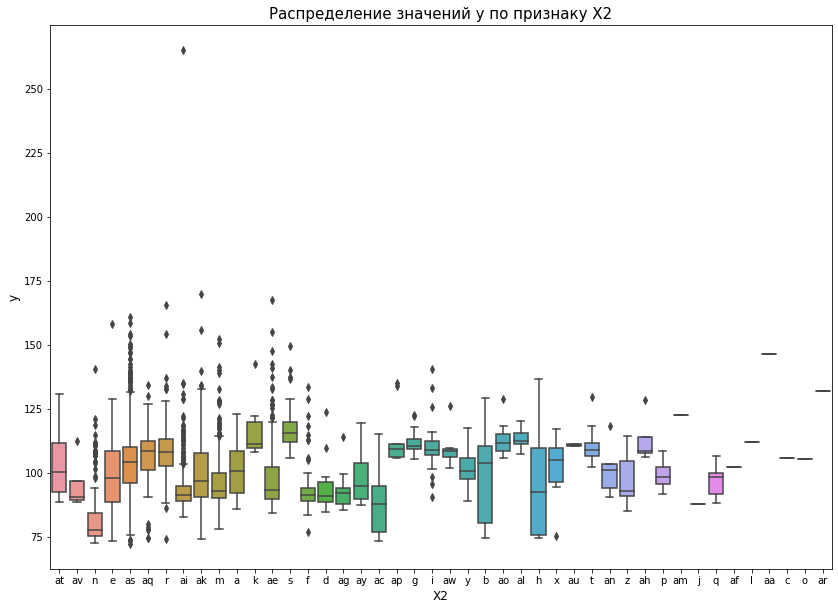

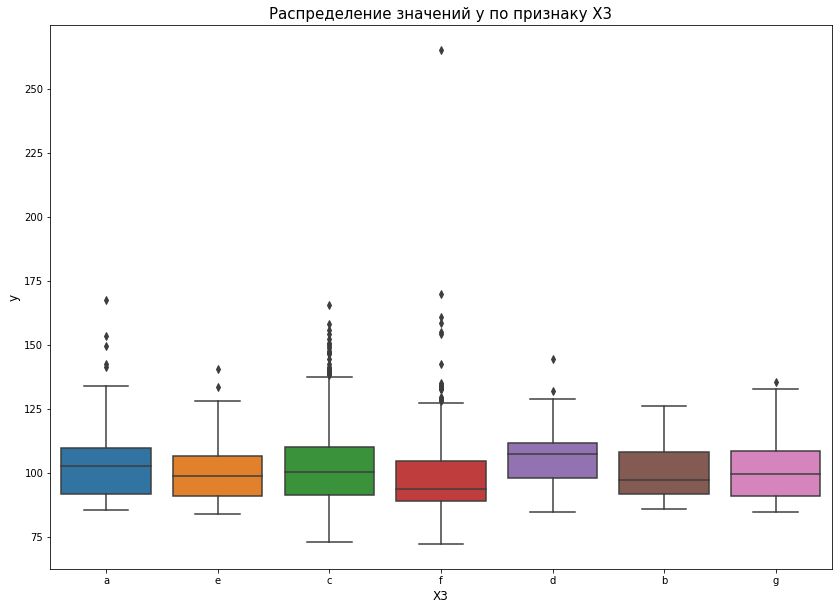

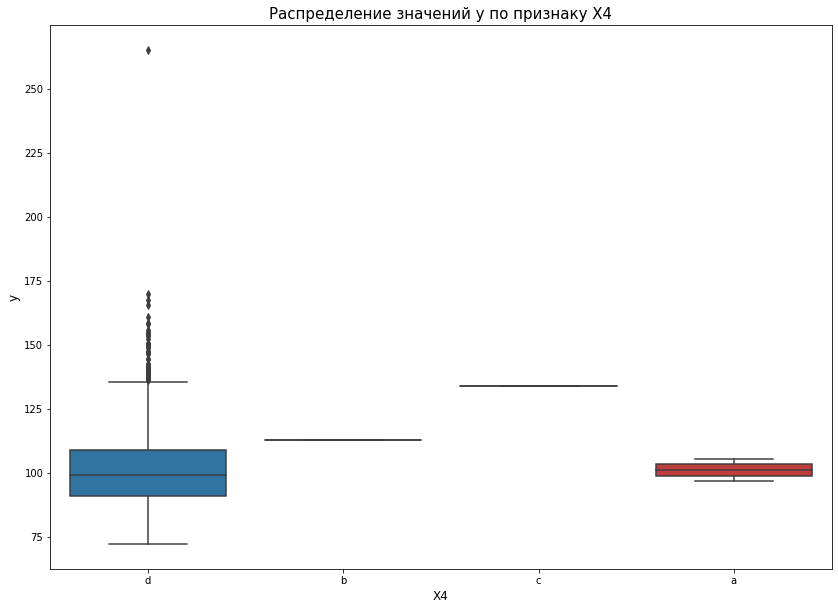

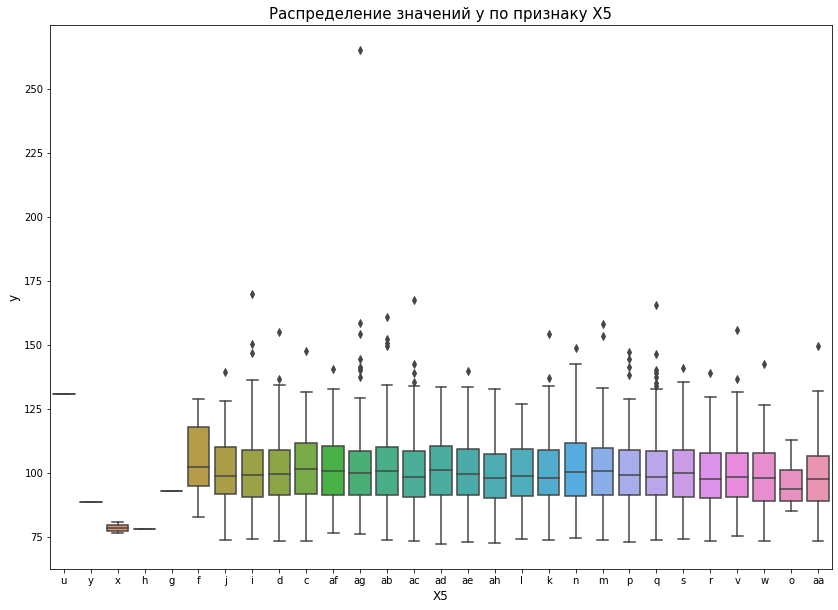

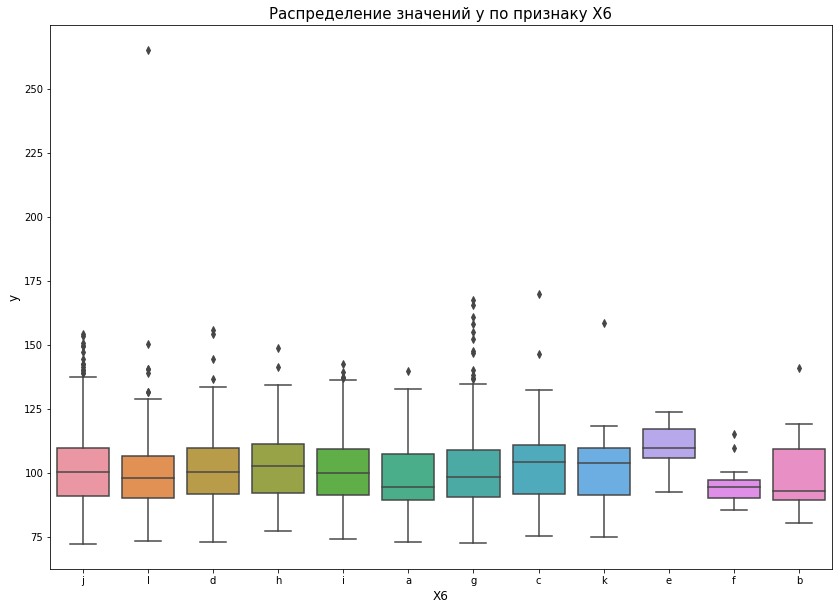

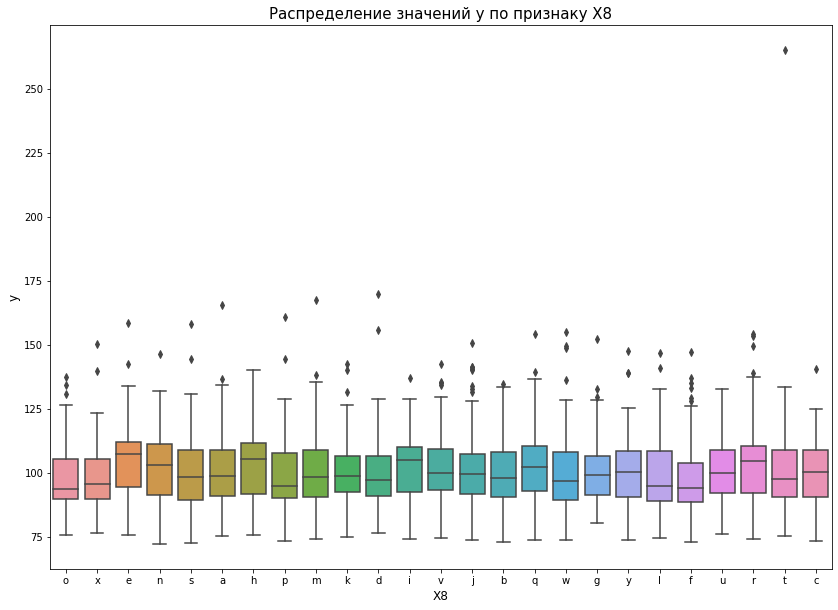

In [ ]:
# смотрим, где есть выбросы
for c in cat_columns:
  plt.figure(figsize=(14,10))
  sns.boxplot(x=c, y='y', data=train_data)
  plt.xlabel(c, fontsize=12)
  plt.ylabel('y', fontsize=12)
  plt.title("Распределение значений y по признаку "+c, fontsize=15)

In [11]:
train_data[train_data['y']>200]

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
883,1770,265.32,y,r,ai,f,d,ag,l,t,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [12]:
np.where(train_data['y']>200)

(array([883]),)

In [13]:
train_data = train_data.drop(np.where(train_data['y']>200)[0])

In [14]:
target = train_data['y'].copy().values

### Binary features

In [15]:
binary_indexes = np.where(train_data.dtypes == 'int64')
binary_columns = train_data.columns[binary_indexes]

In [ ]:
tmp_df = pd.concat([train_data[binary_columns], test_data[binary_columns]])
cor = tmp_df.corr()
cor

,ID,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
ID,1.000000,-0.007990,-0.014268,0.051084,-0.006798,-0.030859,0.003790,-0.030507,-0.029585,-0.018442,-0.016503,0.069122,-0.006852,-0.084770,0.000944,-0.016316,-0.053717,-0.006582,0.031710,0.000013,0.033054,-0.034368,0.014093,0.009349,-0.003241,-0.034368,0.009623,-0.034368,0.256150,0.009349,0.004587,-0.007459,-0.032951,0.011502,-0.062615,-0.018944,0.013508,-0.025364,-0.008045,-0.021935,...,0.037615,0.053844,0.008331,-0.011065,0.082260,-0.056507,-0.049654,0.048586,-0.043988,0.012313,0.026090,-0.042992,-0.013186,-0.011069,-0.019513,0.044415,-0.019722,0.022858,0.036765,-0.053909,-0.052311,-0.007394,0.056890,-0.015433,-0.005423,0.090511,0.010360,-0.020017,0.007635,0.009534,0.034546,-0.083936,-0.009489,0.014034,0.027743,-0.000578,-0.029585,-0.006398,0.000730,0.027636
X10,-0.007990,1.000000,-0.001397,-0.036420,-0.032240,-0.110868,-0.003124,-0.006560,-0.011651,-0.012233,-0.044011,-0.051951,-0.005933,-0.038987,-0.018510,-0.005933,-0.010767,0.077426,-0.022422,-0.026494,-0.009075,-0.055419,-0.013398,-0.002794,-0.008630,-0.055419,-0.007792,-0.055419,-0.023374,-0.002794,-0.004636,-0.013765,0.127058,0.436980,-0.012314,-0.068017,-0.136281,-0.005469,-0.019684,-0.043419,...,-0.019891,-0.028210,-0.001976,0.029808,-0.027285,-0.091986,-0.078210,-0.030062,-0.006254,-0.055392,0.156233,-0.053125,-0.005415,-0.107574,-0.024165,-0.037289,0.024680,0.123355,0.065353,-0.007270,-0.007134,-0.004842,-0.029406,-0.033221,-0.001976,-0.010104,-0.014611,-0.002420,-0.016788,-0.068114,0.177706,-0.030457,-0.080490,-0.018289,-0.013323,-0.011566,-0.011651,-0.004193,-0.003124,-0.005040
X11,-0.014268,-0.001397,1.000000,-0.003098,-0.002742,0.012600,-0.000266,-0.000558,-0.000991,-0.001041,-0.003744,-0.004419,-0.000505,-0.003316,-0.001574,-0.000505,-0.000916,0.007446,-0.001907,-0.002254,-0.000772,-0.006038,-0.001140,-0.000238,-0.000734,-0.006038,-0.000663,-0.006038,-0.001988,-0.000238,-0.000394,-0.001171,-0.000314,-0.003095,-0.001047,-0.006339,-0.013225,-0.001201,-0.001674,-0.004173,...,-0.001692,-0.002399,-0.000168,0.002535,-0.002321,0.015186,0.016963,-0.002557,-0.000532,-0.005508,-0.008518,-0.005142,-0.000461,0.012542,-0.002055,-0.003172,0.002099,-0.011324,0.006299,-0.000618,-0.000607,-0.000412,-0.002501,-0.002826,-0.000168,-0.000859,-0.001243,-0.000206,-0.001428,0.019858,-0.007520,-0.002591,-0.007365,-0.001556,-0.001133,-0.000984,-0.000991,-0.000357,-0.000266,-0.000429
X12,0.051084,-0.036420,-0.003098,1.000000,0.249321,-0.245862,-0.006929,-0.014548,-0.020826,-0.027128,-0.097600,-0.115208,-0.013156,-0.086457,-0.041047,-0.013156,-0.023877,0.185403,-0.049722,-0.033686,-0.020125,-0.126495,-0.029711,-0.006197,-0.019139,-0.126495,-0.017279,-0.126495,-0.008323,-0.006197,-0.010280,-0.030525,-0.008199,-0.080696,-0.027307,0.022925,-0.073227,-0.031320,-0.043651,-0.092566,...,0.110908,-0.062558,-0.004381,0.066102,-0.060507,-0.192543,-0.150838,-0.066665,-0.013870,0.253745,-0.039544,-0.046236,-0.012008,0.090641,-0.053588,0.252473,-0.225080,-0.084546,0.088085,-0.016122,-0.015819,-0.010738,-0.065210,-0.060650,-0.004381,-0.022407,-0.028386,-0.005366,0.162742,0.094633,-0.128385,-0.067542,0.055384,-0.011483,-0.025152,-0.015553,-0.020826,-0.009298,-0.006929,-0.011177
X13,-0.006798,-0.032240,-0.002742,0.249321,1.000000,-0.079624,-0.006133,-0.012879,-0.022872,-0.018705,-0.086398,-0.044295,-0.000776,0.193970,-0.036336,0.010094,-0.021137,0.116868,-0.026268,-0.052010,-0.017816,-0.093138,-0.026301,-0.005486,-0.016942,-0.093138,-0.015296,-0.093138,-0.025973,-0.005486,-0.009101,-0.027022,-0.007258,-0.059968,-0.024173,-0.125494,-0.042281,0.009169,-0.038641,-0.061727,...,-0.039047,-0.055378,-0.003878,0.056240,-0.053562,-0.070335,0.127605,-0.05

In [ ]:
cor.loc[:,:] =  np.tril(cor, k=-1)
cor = cor.stack()
cor[cor > 0.9999].to_dict().keys() # выводим полностью коррелирующие столбцы

dict_keys([('X35', 'X31'), ('X37', 'X31'), ('X37', 'X35'), ('X39', 'X33'), ('X76', 'X54'), ('X84', 'X71'), ('X102', 'X53'), ('X113', 'X48'), ('X119', 'X118'), ('X134', 'X48'), ('X134', 'X113'), ('X146', 'X138'), ('X147', 'X48'), ('X147', 'X113'), ('X147', 'X134'), ('X172', 'X62'), ('X199', 'X112'), ('X213', 'X67'), ('X214', 'X53'), ('X214', 'X102'), ('X216', 'X62'), ('X216', 'X172'), ('X222', 'X48'), ('X222', 'X113'), ('X222', 'X134'), ('X222', 'X147'), ('X226', 'X152'), ('X227', 'X125'), ('X239', 'X53'), ('X239', 'X102'), ('X239', 'X214'), ('X244', 'X71'), ('X244', 'X84'), ('X253', 'X60'), ('X254', 'X230'), ('X262', 'X184'), ('X279', 'X232'), ('X293', 'X290'), ('X296', 'X295'), ('X299', 'X298'), ('X302', 'X44'), ('X324', 'X58'), ('X326', 'X152'), ('X326', 'X226'), ('X330', 'X290'), ('X330', 'X293'), ('X360', 'X155'), ('X364', 'X240'), ('X382', 'X17'), ('X385', 'X60'), ('X385', 'X253')])

In [17]:
columns_to_drop = ['X35', 'X31', 'X39','X48', 'X76', 'X84', 'X102','X113','X119','X134','X147', 'X146', 'X172','X199','X213', 'X214','X216','X226', 'X227', 'X239', 'X244', 'X253', 'X254', 'X262', 'X279', 'X293', 'X296', 'X299', 'X302', 'X324', 'X326', 'X330', 'X360','X364','X382','X385']
reduced_train = train_data.drop(columns_to_drop, axis=1)

In [ ]:
cor_reduced = reduced_train.corr()
cor_reduced.loc[:,:] =  np.tril(cor_reduced, k=-1)
cor_reduced = cor_reduced.stack()
cor_reduced[cor_reduced > 0.95].to_dict().keys()

dict_keys([('X54', 'X29'), ('X90', 'X88'), ('X94', 'X88'), ('X94', 'X90'), ('X120', 'X61'), ('X122', 'X88'), ('X122', 'X90'), ('X122', 'X94'), ('X129', 'X49'), ('X137', 'X58'), ('X140', 'X138'), ('X162', 'X29'), ('X162', 'X54'), ('X215', 'X19'), ('X217', 'X88'), ('X217', 'X90'), ('X217', 'X94'), ('X217', 'X122'), ('X222', 'X198'), ('X232', 'X29'), ('X232', 'X54'), ('X232', 'X162'), ('X242', 'X88'), ('X242', 'X90'), ('X242', 'X94'), ('X242', 'X122'), ('X242', 'X217'), ('X243', 'X88'), ('X243', 'X90'), ('X243', 'X94'), ('X243', 'X122'), ('X243', 'X217'), ('X243', 'X242'), ('X245', 'X89'), ('X247', 'X202'), ('X248', 'X60'), ('X249', 'X88'), ('X249', 'X90'), ('X249', 'X94'), ('X249', 'X122'), ('X249', 'X217'), ('X249', 'X242'), ('X249', 'X243'), ('X250', 'X178'), ('X263', 'X136'), ('X264', 'X126'), ('X266', 'X184'), ('X311', 'X118'), ('X314', 'X261'), ('X320', 'X88'), ('X320', 'X90'), ('X320', 'X94'), ('X320', 'X122'), ('X320', 'X217'), ('X320', 'X242'), ('X320', 'X243'), ('X320', 'X249'),

In [18]:
columns_to_drop.extend(['X54','X90','X94','X99','X101','X80','X120','X129','X137','X140','X215','X217','X162','X222','X232','X242','X243','X122','X245','X247','X248','X249','X250','X250','X263','X264','X266','X311', 'X314','X320','X328','X352','X358','X362','X363','X365'])
reduced_train = train_data.drop(columns_to_drop, axis=1)
reduced_test = test_data.drop(columns_to_drop, axis=1)

In [24]:
from sklearn.cluster import KMeans

def find_clusters(data, column, n):
  clustered = pd.DataFrame()
  clustered['X'] = data[column]
  clustered['y'] = data['y']
  medians = data.groupby(column)['y'].median()
  kmeans = KMeans(n, random_state=0)
  labels = kmeans.fit_predict(medians[data[column].values].values.reshape(-1,1))
  clustered['label']=labels
  inertia = kmeans.inertia_
  return clustered, inertia

Text(0, 0.5, 'inertia')

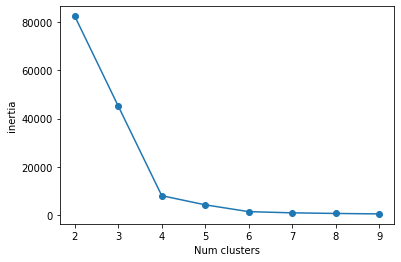

In [25]:
scores = []
for i in range(2,10):
  a, score = find_clusters(reduced_train, 'X0', i)
  scores.append(score)


plt.plot(range(2,10), scores, marker='o')
plt.xlabel('Num clusters')
plt.ylabel('inertia')

In [26]:
data_clustered, _ = find_clusters(train_data, 'X0', 4)
reduced_train['label'] = data_clustered['label']

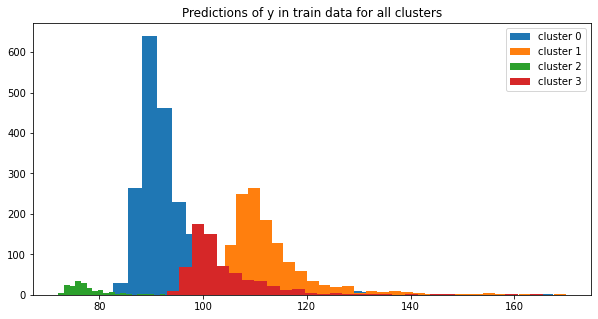

In [27]:
plt.figure(figsize=(10,5))
plt.hist(data_clustered['y'].values[data_clustered['label']==0],bins=30,label='cluster 0')
plt.hist(data_clustered['y'].values[data_clustered['label']==1],bins=30,label='cluster 1')
plt.hist(data_clustered['y'].values[data_clustered['label']==2],bins=30,label='cluster 2')
plt.hist(data_clustered['y'].values[data_clustered['label']==3],bins=30,label='cluster 3')
plt.legend()
plt.title('Predictions of y in train data for all clusters')
plt.show()

In [29]:
reduced_test['label'] = reduced_test['X0'].map(data_clustered.groupby('X')['label'].median())
reduced_test['label'] = reduced_test['label'].fillna(1.)

In [33]:
cat_columns = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8','label']
transformer_steps = [
    ('cat_transformer', OneHotEncoder(), cat_columns),
]

transformer = ColumnTransformer(transformer_steps, remainder='passthrough')

In [34]:
train_len = len(train_data)
all_data = pd.concat([reduced_train.drop(['y'], axis=1), reduced_test],axis=0)
all_data = transformer.fit_transform(all_data)
train_reduced = all_data[:train_len]
test_reduced = all_data[train_len:]

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


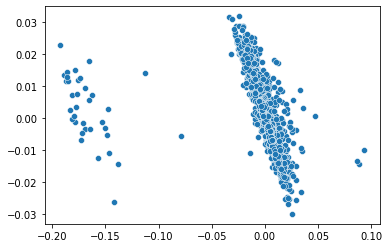

In [36]:
from sklearn.decomposition import FastICA
ica = FastICA(max_iter=1500)
ica_transformed = ica.fit_transform(train_reduced)
sns.scatterplot(ica_transformed[:,0], ica_transformed[:,1])

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


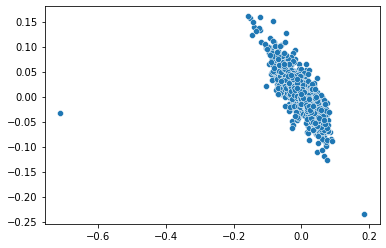

In [37]:
ica = FastICA(max_iter=1500)
ica_transformed_test = ica.fit_transform(test_reduced)
sns.scatterplot(ica_transformed_test[:,0], ica_transformed_test[:,1])

## Prediction

In [38]:
from xgboost import XGBRegressor


In [39]:
def plot_real_predicted(y_real, y_pred):
  x_ax = range(len(y_real))
  plt.figure(figsize=(14,10))
  plt.plot(x_ax, y_real, label="original")
  plt.plot(x_ax, y_pred, label="predicted")
  plt.title("Real and predicted y")
  plt.legend()
  plt.show()

In [40]:
from sklearn.model_selection import train_test_split
def simple_test(data, targets):
  X_train, X_val, y_train, y_val = train_test_split(data, targets, random_state = 1)
  xgbModel=XGBRegressor(max_depth=4, objective='reg:squarederror', random_state=1)
  xgbModel.fit(X_train,y_train, early_stopping_rounds=10, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
  y_pred_val = xgbModel.predict(X_val)
  y_pred_train = xgbModel.predict(X_train)
  plot_real_predicted(y_val, y_pred_val)
  train_score = r2_score(y_train, y_pred_train)
  val_score = r2_score(y_val, y_pred_val)
  return train_score, val_score, xgbModel

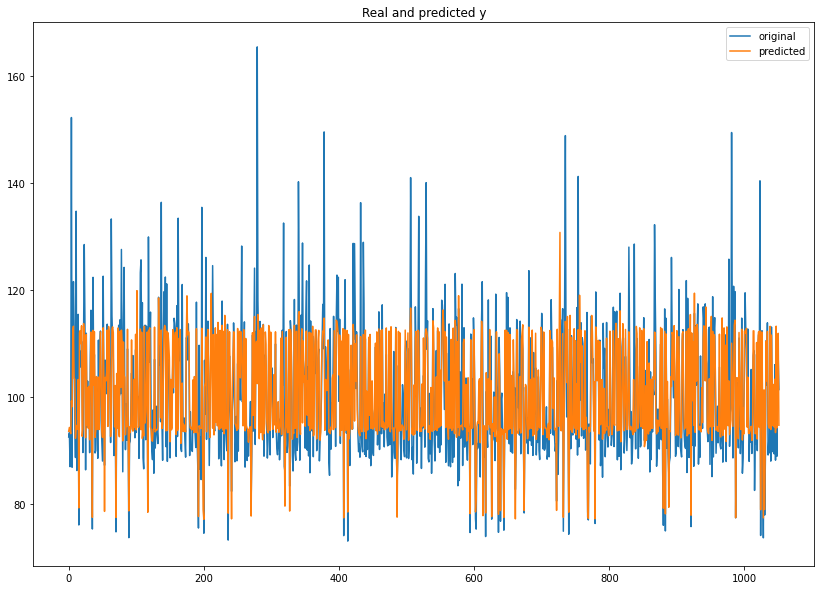

На train-части 0.6596350881068225, на val 0.6022400901691896


In [41]:
targets = train_data['y'].values.reshape(-1,1)
train_score, test_score, _ = simple_test(train_reduced, targets)
print(f'На train-части {train_score}, на val {test_score}')

In [42]:
from sklearn.model_selection import RandomizedSearchCV

params = {'n_estimators':[50, 100, 150],
          'max_depth':[3,4,5], 
          'colsample_bytree':[0.55,0.65,0.75],
          'subsample':[0.35,0.65,0.85,1],
          'gamma':[0.65, 1, 5]}


xg = XGBRegressor(nthread=-1, objective='reg:linear', random_state=1) 

search = RandomizedSearchCV(xg, params, cv=10, verbose=0, n_jobs=-1)
search.fit(train_reduced, target)
search.best_params_

[19:57:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'colsample_bytree': 0.55,
 'gamma': 0.65,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 0.65}

In [43]:
search.best_score_

0.599116406466792

In [45]:
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from joblib import Parallel, delayed


def _parallel_fit_estimator(estimator, X, y, sample_weight=None, **fit_params):
    if sample_weight is not None:
        estimator.fit(X, y, sample_weight=sample_weight, **fit_params)
    else:
        estimator.fit(X, y, **fit_params)
    return estimator


class VotingRegressorXGB(VotingRegressor):
    def fit(self, X, y, sample_weight=None, **fit_params):
        if self.estimators is None or len(self.estimators) == 0:
            raise AttributeError('Invalid `estimators` attribute, `estimators`'
                                 ' should be a list of (string, estimator)'
                                 ' tuples')

        if (self.weights is not None and
                len(self.weights) != len(self.estimators)):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d estimators'
                             % (len(self.weights), len(self.estimators)))

        if sample_weight is not None:
            for name, step in self.estimators:
                if not has_fit_parameter(step, 'sample_weight'):
                    raise ValueError('Underlying estimator \'%s\' does not'
                                     ' support sample weights.' % name)
        names, rgrs = zip(*self.estimators)
        self._validate_names(names)

        n_isnone = np.sum([clf is None for _, clf in self.estimators])
        if n_isnone == len(self.estimators):
            raise ValueError('All estimators are None. At least one is '
                             'required to be a classifier!')

        self.estimators_ = []
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
            delayed(_parallel_fit_estimator)
            (clone(rgr), X, y,**fit_params)
            for rgr in rgrs if rgr is not None
        )

        return self
    
def train_regressor_voting(X_train, Y_train, X_test, Y_test):
    params = {'colsample_bytree': 0.65,
              'gamma': 0.65,
              'max_depth': 3,
              'n_estimators': 50,
              'subsample': 1}
    base_lr = 0.1
    regressors = []
    for i in range(5):
        rgr = XGBRegressor(nthread=-1, objective='reg:linear',
                            **params) 
        regressors.append(('xgb%i'% i, rgr))
    
    fit_params = dict(
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        eval_metric="rmse",
        early_stopping_rounds=14,
    )
    
    voting_rgr = VotingRegressorXGB(regressors, n_jobs=-1)
    voting_rgr.fit(X_train, Y_train, **fit_params)
    return voting_rgr

In [46]:
X_train, X_val, y_train, y_val = train_test_split(train_reduced, target, random_state=100)
rgr = train_regressor_voting(X_train, y_train, X_val, y_val)

In [48]:
pred = rgr.predict(X_val)
r2_score(y_val, pred)

0.5737406228355626

In [49]:
preds = rgr.predict(test_reduced)

In [50]:
submission = {'ID':test_data['ID'].values, 'y':preds}
submission = pd.DataFrame(submission)
submission.head()

,ID,y
0,1,78.361641
1,2,93.749550
2,3,78.459908
3,4,78.361641
4,5,112.008423


In [51]:
submission.to_csv('/content/sample_data/submission.csv', index=False)

In [ ]:
# 0.54665 - итоговый скор